# Implementing an Image Classification App in One Minute

In this tutorial, constructing a LeNet5 model, downloading dataset, training, starting the server and making predictions of the model using TinyMS 0.3.1 API will be demonstrated. 

## Prerequisite
 - Ubuntu: `18.04`
 - docker: `v18.06.1-ce`
 - Jupyter: Using TinyMS 0.3.1-Jupyter, you can refer to [express setup TinyMS](https://tinyms.readthedocs.io/en/latest/quickstart/install.html) to deploy the environment.
 
## Introduction

TinyMS is a high-level API which is designed for amateur of deep learning. It minimizes the number of actions of users required to construct, train, evaluate and serve a model. TinyMS also provides tutorials and documentations for developers.

In [1]:
import os
import json
from PIL import Image

from tinyms import context
from tinyms.data import MnistDataset, download_dataset
from tinyms.vision import mnist_transform, ImageViewer
from tinyms.model import Model, lenet5
import tinyms.optimizers as opt
from tinyms.serving import Server, Client
from tinyms.metrics import Accuracy
from tinyms.losses import SoftmaxCrossEntropyWithLogits
from tinyms.callbacks import ModelCheckpoint, CheckpointConfig, LossMonitor

[WARNING] ME(12716:140477914756928,MainProcess):2021-03-19-15:58:38.621.652 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


### 1. Construct the model

TinyMS encapsulates init and construct of the LeNet5 model, the line of the code is reduced to construct the LeNet5 model:

In [2]:
# build the network
net = lenet5(class_num=10)
model = Model(net)

### 2. Download dataset

The MNIST dataset will be downloaded if `mnist` folder didn't exist at the root. If `mnist` folder already exists, this step will not be performed.

In [3]:
# download the dataset
mnist_path = '/home/jovyan/mnist'
if not os.path.exists(mnist_path):
    download_dataset('mnist', '/home/jovyan')
    print('************Download complete*************')
else:
    print('************Dataset already exists.**************')

************Dataset already exists.**************


### 3. Train the model & evaluation

The dataset for both training and evaluation will be defined here, and the parameters for training also set in this block. A trained ckpt file will be saved to `/home/jovyan/tinyms/serving/lenet5` folder for later use, meanwhile the evaluation will be performed and the `Accuracy` can be checked.

In [ ]:
# check lenet folder exists or not
ckpt_folder = '/home/jovyan/tinyms/serving/lenet5'
ckpt_path = '/home/jovyan/tinyms/serving/lenet5/lenet5.ckpt'
if not os.path.exists(ckpt_folder):
    !mkdir -p  /home/jovyan/tinyms/serving/lenet5
else:
    print('lenet5 ckpt folder already exists')

# set environment parameters
device_target = "CPU"
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)  
dataset_sink_mode = False

# define the training and evaluation dataset
train_dataset = MnistDataset(os.path.join(mnist_path, "train"), shuffle=True)
train_dataset = mnist_transform.apply_ds(train_dataset)
eval_dataset = MnistDataset(os.path.join(mnist_path, "test"), shuffle=True)
eval_dataset = mnist_transform.apply_ds(eval_dataset)

# parameters for training
lr = 0.01
momentum = 0.9
epoch_size = 1
batch_size = 32

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# define the optimizer
net_opt = opt.Momentum(net.trainable_params(), lr, momentum)
net_metrics={"Accuracy": Accuracy()}
model.compile(loss_fn=net_loss, optimizer=net_opt, metrics=net_metrics)

print('************************Start training*************************')
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10))
model.train(epoch_size, train_dataset, callbacks=[ckpoint_cb, LossMonitor()],dataset_sink_mode=dataset_sink_mode)
print('************************Finished training*************************')
model.save_checkpoint(ckpt_path)


model.load_checkpoint(ckpt_path)
print('************************Start evaluation*************************')
acc = model.eval(eval_dataset, dataset_sink_mode=dataset_sink_mode)
print("============== Accuracy:{} ==============".format(acc))

### 4. Define servable.json

Define the lenet5 servable json file for model name, format and number of classes for serving.

In [5]:
servable_json = [{'name': 'lenet5', 
                  'description': 'This servable hosts a lenet5 model predicting numbers', 
                  'model': {
                      "name": "lenet5", 
                      "format": "ckpt", 
                      "class_num": 10}}]
os.chdir("/home/jovyan/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 5. Start server

#### 5.1 Introduction
TinyMS Serving is a C/S(client/server) structure. TinyMS using [Flask](https://flask.palletsprojects.com/en/1.1.x/) which is a micro web framework written in python as the C/S communication tool. In order to serve a model, user must start server first. If successfully started, the server will be run in a subprocess and listening to POST requests from 127.0.0.1 port 5000 sent by client and handle the requests using MindSpore backend which constructs the model, run the prediction and send the result back to the client.

#### 5.2 Start server

Run the following code block to start the server.

In [ ]:
server = Server(serving_path="/home/jovyan/tinyms/serving/")
server.start_server()

 * Serving Flask app 'tinyms.serving.server.server' (lazy loading)

 * Environment: production


   Use a production WSGI server instead.

 * Debug mode: off



The above prompt indicates that the server is started and running.

We're going to open a new Jupiter notebook. Please click the "new" tab on the right side of the page and select Python 3, continue to complete the operation task. The pilot package before operation:

In [ ]:
import os
from PIL import Image
from tinyms.vision import ImageViewer
from tinyms.serving import Server,Client

### 6. Make predictions

#### 6.1 Upload the pic

A picture of a single digit number is required to be the input. The picture we use in this tutorial can be found [HERE](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png), then save the picture to the root folder, and rename it to `7.png` (or any other name you like).

Or run the following code to download the pic for this tutorial:

In [7]:
if not os.path.exists('/home/jovyan/7.png'):
    !wget -P /home/jovyan https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
else:
    print('7.png already exists')

--2021-03-19 15:59:11--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.5, 49.4.112.90, 49.4.112.113, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34970 (34K) [image/png]
Saving to: ‘/root/7.png’

7.png               100%[===================>]  34.15K  --.-KB/s    in 0.09s   

2021-03-19 15:59:12 (371 KB/s) - ‘/root/7.png’ saved [34970/34970]



#### 6.2 List servables

Use `list_servables` function to check what model is being served right now.

In [8]:
client=Client()
client.list_servables()

[{'description': 'This servable hosts a lenet5 model predicting numbers',
  'model': {'class_num': 10, 'format': 'ckpt', 'name': 'lenet5'},
  'name': 'lenet5'}]

If the output `description` shows it is a `lenet5` model, then we can continue to next step to send our request.

#### 6.3 Sending request and get the result

Run `predict` function to send the request, select between `TOP1_CLASS` and `TOP5_CLASS`:

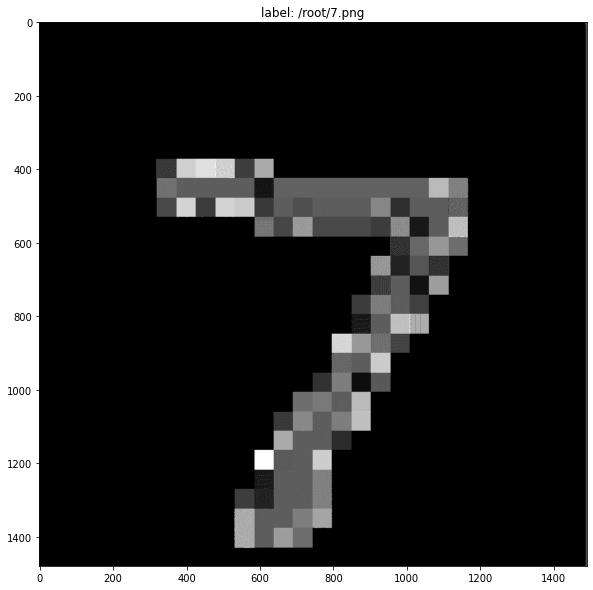

TOP1: 7, score: 0.99943381547927856445


In [9]:
# Set picture path and output policy（You can choose between Top1 and top5）
image_path = "/home/jovyan/7.png"
strategy = "TOP1_CLASS"

# predict(image_path, servable_name, dataset='mnist', strategy='TOP1_CLASS')
img_viewer = ImageViewer(Image.open(image_path), image_path)
img_viewer.show()
print(client.predict(image_path,'lenet5', 'mnist', strategy))

If user can see the output similar to this:  
```
TOP1: 7, score: 0.99934917688369750977
```
that means the prediction is successfully performed.

## Shutdown server

In [10]:
server.shutdown()

'Server shutting down...'